In [1]:
# !python.exe -m pip install --upgrade pip
# !pip3 install pigar -q
import pigar

In [2]:
import numpy as np
import pandas as pd
# import torch

import matplotlib.pyplot as plt
import seaborn as sns

import pathlib as pl

In [3]:
# !pigar generate
# !pip3 install -r requirements.txt -q

In [4]:
DFN = 'data'

In [5]:
def load(csv_fn: str, location: pl.Path =pl.Path('./').joinpath(DFN), **pdkwargs) -> pd.DataFrame:
    """loads CSV file to pandas DataFrame if it exists"""
    try:
        with open(fp := location.joinpath(csv_fn), 'r') as f:
            result = pd.read_csv(f, **pdkwargs)
            print(f"{fp.stat().st_size / 2 ** 20:.3f}MB csv file {fp} has been loaded successfully")
        return result
    except FileNotFoundError:
        print(f"file {csv_fn} doesn't exist")
        return None

def save(dataframe: pd.DataFrame, csv_fn: str ='problem_test_labels.csv', location: pl.Path =pl.Path('./').joinpath(DFN), **pdkwargs):
    """loads CSV file to pandas DataFrame if it exists"""
    result = dataframe.to_csv(fp := location.joinpath(csv_fn), **pdkwargs)
    print(f"{fp.stat().st_size / 2 ** 20:.3f}MB csv file {fp} has been saved successfully")

In [6]:
train_df = load('problem_train.csv', low_memory=False)
test_df = load('problem_test.csv', low_memory=False)
labels_df = load('problem_labels.csv')

14.085MB csv file data\problem_train.csv has been loaded successfully
3.539MB csv file data\problem_test.csv has been loaded successfully
0.263MB csv file data\problem_labels.csv has been loaded successfully


In [7]:
# everything (except auto-indexing as object) is treated as int64
labels_df.dtypes.unique(), labels_df.shape, labels_df.select_dtypes(include=['int64']).columns.size

(array([dtype('int64')], dtype=object), (8000, 15), 15)

In [8]:
labels_df

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,10898,1,1,1,0,0,0,1,0,0,1,1,1,1,1
7996,16664,0,0,0,0,0,0,0,0,0,1,1,0,0,0
7997,5334,1,0,0,0,0,0,0,0,0,1,1,0,0,0
7998,7905,1,1,1,0,0,0,0,0,0,1,1,0,0,0


# Preprocessing intro
We have multi-label classification task with 15 classes

First of all, task provides 0 domain knowledge, I have no idea what's behind that data

There is a lot of missing values and only 32 columns do not contain any missing data. Amongst those lies the 'id' column that must be discarded as all samples are considered IID and their order must not matter

Data has both categorical and numerical (integer and float) features

In [9]:
# we've inferred text, float and integer dtypes from train data
train_df.dtypes.unique()
# type O means strings, pandas stores pointers to strings (python objects) instead of strings themselves 
train_df.select_dtypes(include=['O']).columns.size, train_df.select_dtypes(include=['float64']).columns.size, train_df.select_dtypes(include=['int64']).columns.size

(1025, 345, 9)

In [10]:
sum((1025, 345, 9)) == train_df.columns.size

True

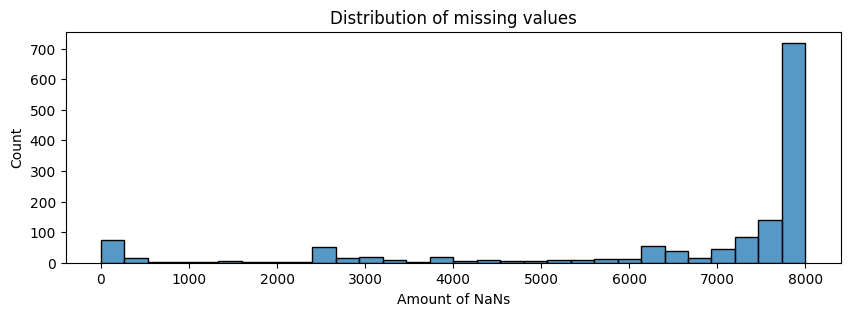

In [11]:
# missing values per column
fig, ax = plt.subplots(figsize=(10,3)) 
plt.title('Distribution of missing values')
plt.xlabel('Amount of NaNs')
ax = sns.histplot(train_df.isnull().sum(axis=0), ax=ax)

## NaN treatment
Since every row contains NaN values in at least 1 column, we can't just drop those and there is no rows with all NaNs (even w/o id and release columns)

Nevertheless, there are 30 columns with NaN only values that must be discarded (unless test data contains those -- and it doesn't)

In [12]:
# rows with at least 1 NaN
train_df[train_df.isnull().any(axis=1)].shape[0]

8000

In [13]:
# columns without NaNs
train_df[train_df.columns[~train_df.isnull().any(axis=0)]].shape[1]

32

In [14]:
# columns with all NaNs
nan_cols_common = train_df.columns[train_df.isnull().all(axis=0)]
# ensures that train and test data have common all-NaN columns
(test_df.columns[train_df.isnull().all(axis=0)] == train_df.columns[train_df.isnull().all(axis=0)]).all(), nan_cols_common.shape[0]
# train_df[allnan_cols]

(True, 30)

Unfortunately, train and test data have different distributions, for instance, test data has 5x more empty columns. And that's troublesome since even inferred dtypes of such columns in two dataset parts differ

Luckily, all-NaN columns in one dataset correspond to almost-all-NaN columns in its counterpart and could be discarded

Therefore, we have right to get rid of 1+30+154=185 columns at once

In [15]:
nan_cols_train = train_df.columns[train_df.isna().all(axis=0)]
nan_cols_test = test_df.columns[test_df.isna().all(axis=0)]
nan_cols_train.size, nan_cols_test.size

(30, 179)

In [16]:
nan_diff_train = nan_cols_train.difference(nan_cols_test) # exclusive train nans
nan_diff_test = nan_cols_test.difference(nan_cols_train) # exclusive test nans
nan_diff_train.size, nan_diff_test.size

(5, 154)

In [17]:
# They correspond to ~NaN columns in the other dataset parts and could be discarded
train_df[nan_diff_test].nunique().mean(), test_df[nan_diff_train].nunique().mean()

(1.6233766233766234, 1.0)

In [18]:
discard_base = pd.Index(['id']).union(nan_cols_common).union(nan_diff_train).union(nan_diff_test)
discard_base

Index(['c_0342', 'c_0354', 'c_0370', 'c_0375', 'c_0378', 'c_0404', 'c_0407',
       'c_0411', 'c_0429', 'c_0431',
       ...
       'o_0299', 'o_0300', 'o_0302', 'o_0306', 'o_0308', 'o_0309', 'o_0311',
       'o_0317', 'o_0318', 'o_0320'],
      dtype='object', length=185)

In [19]:
train_df_ = train_df.drop(discard_base, axis=1)
test_df_ = test_df.drop(discard_base, axis=1)
test_df_.shape, test_df.shape

((2000, 1194), (2000, 1379))

## Integer part
It contains just 9 (8) columns without any missing values. 'id' column has to be discarded, moreover there are 6 constant columns that aren't valid features

In [20]:
int_part = train_df_.select_dtypes(include=['int64'])
int_part.describe()

,n_0047,n_0050,n_0052,n_0061,n_0075,n_0091,o_0176,o_0264
count,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.000000,8000.000000
mean,1.0,1.0,1.0,1.0,1.0,1.0,198.395500,4.585875
std,0.0,0.0,0.0,0.0,0.0,0.0,118.487761,2.237912
min,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000
25%,1.0,1.0,1.0,1.0,1.0,1.0,92.000000,4.000000
50%,1.0,1.0,1.0,1.0,1.0,1.0,193.000000,5.000000
75%,1.0,1.0,1.0,1.0,1.0,1.0,315.000000,6.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,369.000000,10.000000


In [21]:
#ensure that we have inferred the same dtype for test data
int_part_test = test_df_.select_dtypes(include=['int64'])
(int_part_test.columns == int_part.columns).all()

True

In [22]:
# Invalid features
dump_extra_i = int_part.columns[int_part.nunique() == 1]
dump_extra_i

Index(['n_0047', 'n_0050', 'n_0052', 'n_0061', 'n_0075', 'n_0091'], dtype='object')

## String part
Treated as categorical features, contains 1025 (911) sparse columns with latin letters (33 lowercase latin letters, the only unique string value amongst top-50 columns is "**p**") and many missing values

It's not clearly ordinal (doesn't have any strong order except an alphabetical) and should be (ideally) one-hot-encoded (columnwise) as it doesn't bring any semantic meaning

Nevertheless, I don't want to blow up feature amount with OHE (=>excessively boosting its influence on prediction) or discard features even with 99% of NaNs (like **o_0320**) at this stage, that's why i am going to implement ordinal encoding for all categorical features while treating NaNs as a separate entity (encoded as -1 by pd.factorize)

In [23]:
string_part_train = train_df_.select_dtypes(include=['O'])
string_part_train.describe()

,release,c_0327,c_0328,c_0329,c_0330,c_0331,c_0332,c_0333,c_0334,c_0335,...,c_1366,c_1367,c_1369,c_1370,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
count,8000,22,512,5,157,6,1690,482,26,821,...,1050,1,48,377,7998,440,3155,563,7,1908
unique,3,2,5,4,6,3,2,2,9,5,...,6,1,11,3,2,5,24,19,2,2
top,a,a,d,e,c,c,a,b,i,b,...,a,a,m,b,a,c,b,j,b,b
freq,3838,12,248,2,68,4,1498,383,15,468,...,342,1,22,312,7460,167,1559,232,4,1441


In [24]:
#ensure that we have the same dtype for test data
string_part_test = test_df_.select_dtypes(include=['O'])
(string_part_test.columns == string_part_train.columns).all()

True

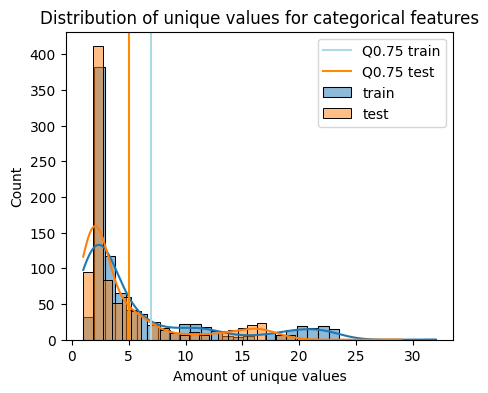

In [25]:
# plot distribution of unique values
uniq_per_col_s_train = string_part_train.nunique()
uniq_per_col_s_test = string_part_test.nunique()
#let's also calculate some quantile to the distribution plot
Q_uniq = 0.75
plt.figure(figsize=(5,4))
plt.title('Distribution of unique values for categorical features')
plt.xlabel('Amount of unique values')
ax = sns.histplot(uniq_per_col_s_train, kde=True, bins=33, label='train')
ax = sns.histplot(uniq_per_col_s_test, kde=True, ax=ax, bins=33, label='test')
plt.axvline(np.quantile(uniq_per_col_s_train, q=Q_uniq), color='lightblue', label=f'Q{Q_uniq} train')
plt.axvline(np.quantile(uniq_per_col_s_test, q=Q_uniq), color='darkorange', label=f'Q{Q_uniq} test')
ax.legend()

In [26]:
# find columns with top-5 by unique values
uniq_per_col_s_train.sort_values(ascending=False).head(5), train_df_['c_1259'].unique()

(c_1259    32
 c_1374    24
 c_1109    23
 c_1045    23
 c_0391    23
 dtype: int64,
 array(['n', 'e', 'w', 'm', 'p', 's', 'u', 'k', 'j', 'b', 'i', 'B', 'q',
        'a', 'h', 'G', 'c', 'd', 'C', 'v', 'y', 'D', 'o', 'l', 'A', 'z',
        't', 'r', 'F', 'x', 'g', 'f'], dtype=object))

In [27]:
from functools import reduce
# establish top K columns (by amount of unique strings) in dataframe
df_string_sample = uniq_per_col_s_train.sort_values(ascending=False).head(10).index
# extract unique values
df_string_sample_cols = [train_df_[cn].dropna().unique() for cn in df_string_sample]
# compare, find intersection
reduce(np.intersect1d, df_string_sample_cols) # ~ map and accumulate

array(['a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 's', 't', 'u', 'v', 'w'], dtype=object)

In [28]:
# list all possible unique values,
pd.unique(string_part_train.values.ravel('K'))

array(['a', 'c', 'b', nan, 'd', 'e', 'f', 'i', 'h', 'k', 'm', 'g', 'r',
       's', 'o', 'j', 'l', 'q', 'p', 't', 'n', 'w', 'u', 'v', 'x', 'y',
       'B', 'G', 'C', 'D', 'A', 'z', 'F'], dtype=object)

In [29]:
# they are same for both parts
set(pd.unique(string_part_train.values.ravel('K'))) == set(pd.unique(string_part_test.values.ravel('K')))

True

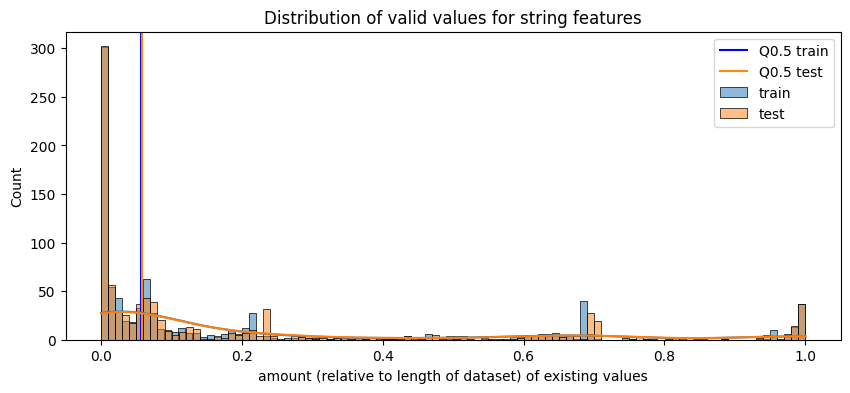

In [30]:
# sparsity of feature columns
exist_per_col_s_train = string_part_train.shape[0] - string_part_train.isna().sum(axis=0)
exist_per_col_s_test = string_part_test.shape[0] - string_part_test.isna().sum(axis=0)
Q_exist = 0.5
plt.figure(figsize=(10,4))
plt.title('Distribution of valid values for string features')
plt.xlabel('amount (relative to length of dataset) of existing values')
plt.axvline(np.quantile(exist_per_col_s_train/max(exist_per_col_s_train), q=Q_exist), color='blue', label=f'Q{Q_exist} train')
plt.axvline(np.quantile(exist_per_col_s_test/max(exist_per_col_s_test), q=Q_exist), color='darkorange', label=f'Q{Q_exist} test')
ax = sns.histplot(exist_per_col_s_train/max(exist_per_col_s_train), kde=True, bins=100, label='train')
ax = sns.histplot(exist_per_col_s_test/max(exist_per_col_s_test), kde=True, bins=100, ax=ax, label='test')
ax.legend()

In [31]:
# filters out columns with #existing values < threshold for both train and test counterparts
thr_low_string = 10
s_dump_test_ = string_part_test.columns[exist_per_col_s_test < thr_low_string]
s_dump_train_ = string_part_train.columns[exist_per_col_s_train < thr_low_string]
s_refined_train_mask = string_part_test.shape[0] - test_df[s_dump_train_].isna().sum() < thr_low_string # columns that have already been dumped from train and could be dumped from test
s_refined_test_mask =  string_part_train.shape[0] - train_df[s_dump_test_].isna().sum() < thr_low_string # columns that have already been dumped from test and could be dumped from train
dump_extra_s = s_refined_test_mask.index[s_refined_test_mask].union(s_refined_train_mask.index[s_refined_train_mask])
dump_extra_s

Index(['c_0329', 'c_0331', 'c_0346', 'c_0359', 'c_0381', 'c_0417', 'c_0435',
       'c_0440', 'c_0446', 'c_0455',
       ...
       'c_1321', 'c_1324', 'c_1329', 'c_1336', 'c_1339', 'c_1344', 'c_1356',
       'c_1358', 'c_1367', 'c_1376'],
      dtype='object', length=103)

In [32]:
dump_extra_s.isin(['c_0487'])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

## Float part
Contains 345 (275) columns with a lot of missing values, only 4 columns have none

Train/test data contains some empty (and almost empty columns) that can't or/and shouldn't be imputed. Those NaNs are strongly ($\rho= 0.87$) correlated with float NaNs, i.e. used to come together

I am not going to discard columns with low variance at this stage but I will compare train with test data disribution by their std

Furthermore, there are features with a few unique values (integers or half-integers with same intervals) that could be casted to int or treated as categorical

In [33]:
float_part_train = train_df_.select_dtypes(include=['float64'])
float_part_train.describe()

,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0009,n_0010,...,o_0314,o_0315,o_0316,o_0319,o_0321,o_0322,o_0323,o_0324,o_0325,o_0326
count,12.000000,388.000000,7662.000000,112.000000,58.000000,7658.000000,1348.000000,995.000000,34.000000,26.000000,...,1695.00000,4001.000000,397.000000,671.000000,2.000000,182.000000,1694.000000,550.000000,12.000000,743.000000
mean,0.307692,0.655744,0.040935,0.102749,0.352874,0.395981,0.193175,0.012012,0.129241,0.361538,...,0.00354,0.086978,5.080605,5.651267,1.000000,18.675824,0.009445,1.209091,0.583333,5.282638
std,0.245454,0.216399,0.024599,0.153007,0.209337,0.085000,0.236683,0.041382,0.162008,0.204112,...,0.06863,0.322386,3.416914,3.442577,1.414214,6.327120,0.137157,0.699928,0.514929,3.470446
min,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.100000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.134615,0.428571,0.031974,0.011905,0.200000,0.342105,0.000000,0.000000,0.015560,0.200000,...,0.00000,0.000000,2.000000,3.000000,0.500000,14.000000,0.000000,1.000000,0.000000,2.000000
50%,0.307692,0.702381,0.041369,0.047619,0.283333,0.394737,0.200000,0.000000,0.049793,0.300000,...,0.00000,0.000000,5.000000,6.000000,1.000000,19.000000,0.000000,1.000000,1.000000,5.000000
75%,0.403846,0.857143,0.048950,0.142857,0.525000,0.421053,0.400000,0.011905,0.186722,0.400000,...,0.00000,0.000000,8.000000,9.000000,1.500000,23.750000,0.000000,2.000000,1.000000,8.000000
max,0.846154,1.000000,1.000000,1.000000,0.833333,1.000000,1.000000,1.000000,0.597510,1.000000,...,2.00000,5.000000,11.000000,11.000000,2.000000,32.000000,3.000000,2.000000,1.000000,11.000000


In [34]:
#ensure that we have the same dtype for test data
float_part_test = test_df_.select_dtypes(include=['float64'])
(float_part_test.columns == float_part_train.columns).all()

True

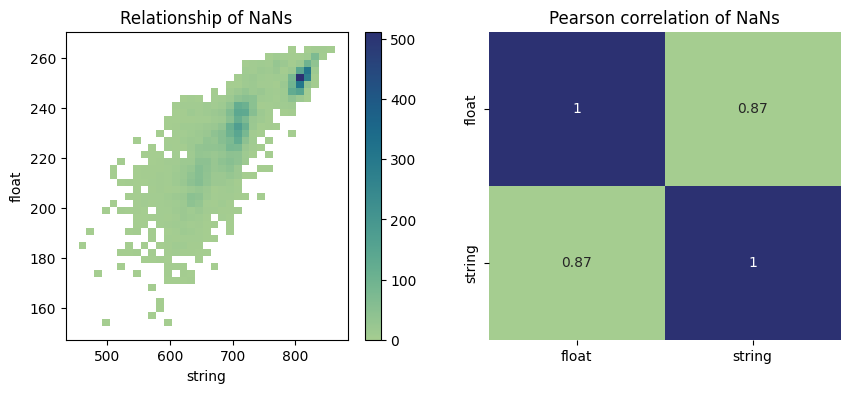

In [35]:
#NaN relationship
fig, ax = plt.subplots(1,2, figsize=(10,4)) 
rel = pd.concat([float_part_train.isna().sum(axis=1), string_part_train.isna().sum(axis=1)], axis=1)
ax[0].set_title('Relationship of NaNs')
ax[0].set_xlabel('string')
ax[0].set_ylabel('float')
ax[0] = sns.histplot(rel, x=1, y=0, cbar=True, cmap='crest', ax=ax[0])
ax[1].set_title('Pearson correlation of NaNs')
ax[1] = sns.heatmap(rel.corr(), cmap='crest', ax=ax[1], xticklabels=['float','string'], yticklabels=['float','string'], annot=True, cbar=False)
# h = sns.jointplot(rel, x=1, y=0, s=4)
# h.set_axis_labels('string NaNs', 'float NaNs')

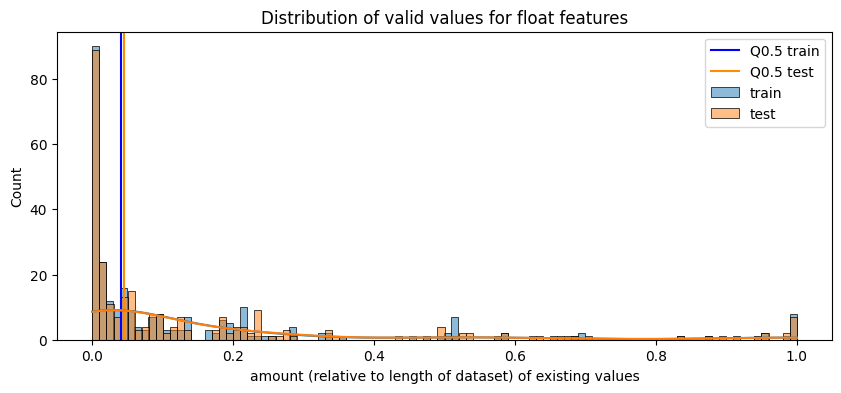

In [36]:
# sparsity of feature columns
exist_per_col_f_train = float_part_train.shape[0] - float_part_train.isna().sum(axis=0)
exist_per_col_f_test = float_part_test.shape[0] - float_part_test.isna().sum(axis=0)
Q_exist = 0.5
plt.figure(figsize=(10,4))
plt.title('Distribution of valid values for float features')
plt.xlabel('amount (relative to length of dataset) of existing values')
plt.axvline(np.quantile(exist_per_col_f_train/max(exist_per_col_f_train), q=Q_exist), color='blue', label=f'Q{Q_exist} train')
plt.axvline(np.quantile(exist_per_col_f_test/max(exist_per_col_f_test), q=Q_exist), color='darkorange', label=f'Q{Q_exist} test')
ax = sns.histplot(exist_per_col_f_train/max(exist_per_col_f_train), kde=True, bins=100, label='train')
ax = sns.histplot(exist_per_col_f_test/max(exist_per_col_f_test), kde=True, bins=100, ax=ax, label='test')
ax.legend()

In [37]:
# filters out columns with #existing values < threshold for both train and test counterparts
thr_low_float = 50
f_dump_test_ = float_part_test.columns[exist_per_col_f_test < thr_low_float]
f_dump_train_ = float_part_train.columns[exist_per_col_f_train < thr_low_float]
f_refined_train_mask = float_part_test.shape[0] - test_df[f_dump_train_].isna().sum() < thr_low_float # columns that have already been dumped from train and could be dumped from test
f_refined_test_mask = float_part_train.shape[0] - train_df[f_dump_test_].isna().sum() < thr_low_float # columns that have already been dumped from test and could be dumped from train
dump_extra_f = f_refined_test_mask.index[f_refined_test_mask].union(f_refined_train_mask.index[f_refined_train_mask])
dump_extra_f

Index(['n_0000', 'n_0009', 'n_0010', 'n_0018', 'n_0021', 'n_0023', 'n_0032',
       'n_0033', 'n_0042', 'n_0045', 'n_0053', 'n_0062', 'n_0063', 'n_0065',
       'n_0072', 'n_0081', 'n_0082', 'n_0085', 'n_0092', 'n_0103', 'n_0112',
       'o_0118', 'o_0119', 'o_0124', 'o_0130', 'o_0131', 'o_0133', 'o_0134',
       'o_0136', 'o_0143', 'o_0146', 'o_0150', 'o_0151', 'o_0155', 'o_0156',
       'o_0160', 'o_0161', 'o_0162', 'o_0169', 'o_0172', 'o_0174', 'o_0178',
       'o_0180', 'o_0186', 'o_0192', 'o_0193', 'o_0195', 'o_0200', 'o_0203',
       'o_0205', 'o_0207', 'o_0209', 'o_0214', 'o_0218', 'o_0225', 'o_0234',
       'o_0238', 'o_0239', 'o_0244', 'o_0254', 'o_0255', 'o_0258', 'o_0262',
       'o_0267', 'o_0272', 'o_0287', 'o_0288', 'o_0294', 'o_0303', 'o_0307',
       'o_0310', 'o_0321', 'o_0325'],
      dtype='object')

In [38]:
# finds columns with thr_low_ <= #existing values <= ratio_up*length for train or test counterparts
ratio_up = 0.5
double_test_ = float_part_test.columns[exist_per_col_f_test.between(thr_low_float, ratio_up * float_part_test.shape[0], inclusive='both')]
double_train_ = float_part_train.columns[exist_per_col_f_train.between(thr_low_float, ratio_up * float_part_train.shape[0], inclusive='both')]
double_total = double_test_.union(double_train_)
double_total

Index(['n_0001', 'n_0003', 'n_0004', 'n_0006', 'n_0007', 'n_0013', 'n_0014',
       'n_0015', 'n_0016', 'n_0017',
       ...
       'o_0312', 'o_0313', 'o_0314', 'o_0315', 'o_0316', 'o_0319', 'o_0322',
       'o_0323', 'o_0324', 'o_0326'],
      dtype='object', length=173)

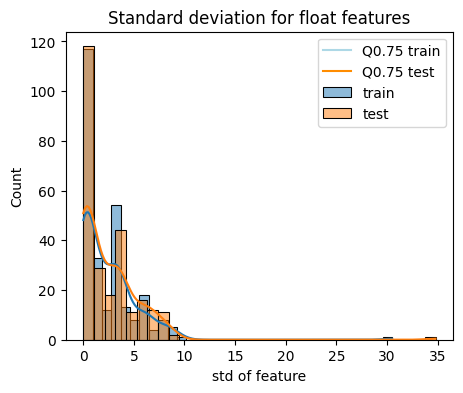

In [39]:
# plot distribution of stds (ignoring NaNs)
std_per_col_f_train = float_part_train.std()
std_per_col_f_test = float_part_test.std()
#let's also calculate some quantile to the distribution plot
Q_var = 0.75
plt.figure(figsize=(5,4))
plt.title('Standard deviation for float features')
plt.xlabel('std of feature')
ax = sns.histplot(std_per_col_f_train, kde=True, bins=33, label='train')
ax = sns.histplot(std_per_col_f_test, kde=True, ax=ax, bins=33, label='test')
plt.axvline(np.quantile(std_per_col_f_train, q=Q_var), color='lightblue', label=f'Q{Q_uniq} train')
plt.axvline(np.quantile(std_per_col_f_test, q=Q_var), color='darkorange', label=f'Q{Q_uniq} test')
ax.legend()

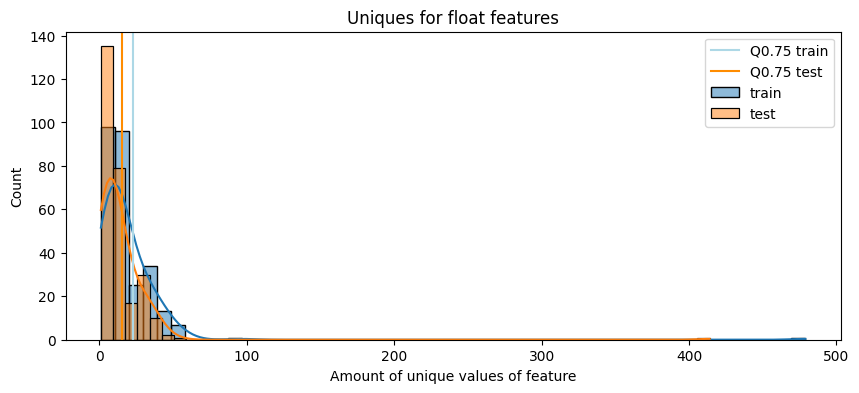

In [40]:
# plot distribution of unique values
uniq_per_col_f_train = float_part_train.nunique()
uniq_per_col_f_test = float_part_test.nunique()
#let's also calculate some quantile to the distribution plot
Q_unq = 0.75
plt.figure(figsize=(10,4))
plt.title('Uniques for float features')
plt.xlabel('Amount of unique values of feature')
ax = sns.histplot(uniq_per_col_f_train, kde=True, bins=50, label='train')
ax = sns.histplot(uniq_per_col_f_test, kde=True, ax=ax, bins=50, label='test')
plt.axvline(np.quantile(uniq_per_col_f_train, q=Q_unq), color='lightblue', label=f'Q{Q_uniq} train')
plt.axvline(np.quantile(uniq_per_col_f_test, q=Q_unq), color='darkorange', label=f'Q{Q_uniq} test')
ax.legend()

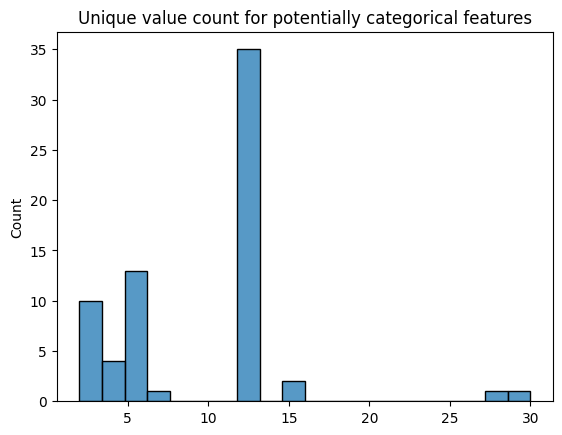

In [41]:
# retrieve features with same set of unique values for test and train parts
equiunique_cols_ = float_part_train.columns[float_part_test.nunique()==float_part_train.nunique()] # restrict to columns with same amt of uniques first
# we have to fill nans with some other (+ignored by pandas) number since nan != nan and messes everything 
eq_uniques_test = float_part_test[equiunique_cols_].fillna(np.inf).apply(pd.unique, axis=0).apply(set)
eq_uniques_train = float_part_train[equiunique_cols_].fillna(np.inf).apply(pd.unique, axis=0).apply(set)
equiunique_cols = equiunique_cols_[eq_uniques_test == eq_uniques_train]
plt.title('Unique value count for potentially categorical features')
ax = sns.histplot(float_part_train[equiunique_cols].nunique(), bins=20)

In [42]:
# filters out columns with #unique < threshold and not NaN for both train and test counterparts, to be transformed to categorical\int
discr_subset = float_part_train[float_part_train[equiunique_cols].columns[float_part_train[equiunique_cols].nunique() <12]].fillna(666.666) 
change_floats = discr_subset.columns[(discr_subset.astype(int) == discr_subset).any(axis=0)]
float_part_train[change_floats].apply(pd.unique)

n_0006         [nan, 0.2, 0.0, 0.4, 0.6, 0.8, 1.0]
n_0013                             [nan, 0.0, 1.0]
n_0023                        [nan, 0.0, 1.0, 0.5]
n_0036                        [nan, 0.0, 0.5, 1.0]
n_0089                        [nan, 0.5, 0.0, 1.0]
n_0104                        [nan, 0.0, 0.1, 0.2]
o_0120    [0.0, 2.0, 6.0, 1.0, 3.0, 5.0, 4.0, nan]
o_0129              [nan, 0.0, 1.0, 2.0, 4.0, 3.0]
o_0147         [4.0, nan, 1.0, 3.0, 2.0, 5.0, 0.0]
o_0152         [nan, 0.0, 3.0, 4.0, 1.0, 5.0, 2.0]
o_0153         [4.0, 5.0, nan, 2.0, 3.0, 1.0, 0.0]
o_0154                   [nan, 0.0, 1.0, 2.0, 3.0]
o_0167                        [nan, 0.0, 2.0, 1.0]
o_0193                             [nan, 0.0, 1.0]
o_0197         [nan, 1.0, 2.0, 4.0, 0.0, 3.0, 5.0]
o_0201              [0.0, 2.0, 1.0, 4.0, nan, 3.0]
o_0205         [nan, 4.0, 1.0, 5.0, 3.0, 2.0, 0.0]
o_0212         [nan, 2.0, 1.0, 3.0, 0.0, 4.0, 5.0]
o_0230                   [1.0, 2.0, 0.0, 3.0, nan]
o_0254                        [

## Preprocessing strategy

### Unsupervised
1) exclude id column
2) get rid of all-NaN columns (check both counterparts)
3) get rid of all-NaN columns in one part and almost-all-NaN in another at once
5) split the dataframe onto 3 parts by dtype, compare dtype in both counterparts
7) cast all strings to pandas categorical dtype
8) extract int/categorical out of floats (~they occur in both parts of the data with identical small set of values)
9) concatenate categoricals and use ordinal encoder (pandas approach, NaNs are treated as a separate category -1)
10) initial absense (low-variance) threshold, get rid of almost-all-NaN columns in both categorical parts (optional, by threshold *thr_low_string=10*)
11) initial absense (low-variance) threshold, get rid of almost-all-NaN columns in both numerical parts (optional, by threshold *thr_low_float=50*)
12) create an extra column for features with thr_low_float <= #existing values <= ratio_up*length, ratio=0.5
13) median imputing for all numerical

### Supervised
1) Normality test: t-test is invalid only for small non-normal datasets. I assume that my sample size is that large I don't need Shapiro-Wilk test.

   I will stick to CLT instead, that says that sample means become normally distributed with a larger sample size
   
3) Ensure homogeneity of variances (plot distribution of their difference in train data)

4) Univariate feature selection for numerical input, categorical targets leads to t-test  
   - Implementation: multilabel classification task is equivalent to 15 independent binary tasks, I prefer ANOVA F-test from sklearn which translates to t-test as we have just 2 groups
   - Intepretation: F-test evaluates against hypothesis H0: groups (2, by target value) have same (feature-wise) means thus low p-values ~ higher feature importance
   - ANOVA significance level: $\alpha=0.95$, non-extreme because univariate test is not a silver bullet, doesn't account for feature interaction
   - Multilabel approach: a feature might be a great discriminator for just 1 class thus I consider min(p_values for classes) to decide whether it's needed
     
6) Multivariate feature selection
   - Test for outliers (by Z-score), select outlier columns with huge $z_score > z\_threshold = 18$ or large percentage of outliers, $pr\_treshold = 5\%$
   - Feature scaling (Z-score normalization and Robust median scaling for selected outliers)
   - Estimator: SVC with L1-norm/Logistic Regression
   - Method: Recursive feature elimination with stratified cross-validation
   - Multilabel approach: Use MultiOutputClassifier wrapper from sklearn with a chosen estimator

### Extra
- Check balance of classes
- cast to a single dtype (double)

In [43]:
def base_preprocessing(dframe: pd.DataFrame, 
                       global_discard: pd.Index =discard_base.union(dump_extra_i).union(dump_extra_s).union(dump_extra_f), 
                       global_double: pd.Index =double_total,
                       global_change: pd.Index =change_floats,
                      ) -> pd.DataFrame:
    '''unsupervised processing for raw data, eliminates missing values, casts to float64 for numpy\Torch'''
    # eliminate id column, allNaN columns for test and train datasets and (optional ~NaN removal)
    result_ = dframe.drop(global_discard, axis=1)
    # split by value type and treat string columns as categorical features
    int_part = result_.select_dtypes(include=['int64'])
    float_part_ = result_.select_dtypes(include=['float64'])
    string_part = result_.select_dtypes(include=['O']).astype('category')
    # cast potential categoricals from float to categorical and merge with the rest
    ex_floats = float_part_[global_change.difference(global_discard)].astype('category')
    float_part = float_part_.drop(ex_floats, axis=1) # exclude
    cat_part = pd.concat([string_part, ex_floats], axis=1) #add
    # encode & handle the rest of categorical NaNs
    cat_part = cat_part.apply(lambda col: col.cat.codes) # ~ ordinal encoding with all NaNs -> -1
    # impute missing values with a median (robust to outliers) value
    float_part_filled = float_part.fillna(value=float_part.median(axis=0))
    # create extra categorical features highlighting imputed NaNs (whether a column has enough stats to get confident mean/median but not enough to keep variance of data distribution)
    cat_extra = dframe[global_double].isna().add_suffix('_').astype('category').apply(lambda col: col.cat.codes)
    result = pd.concat([int_part, cat_part, float_part_filled, cat_extra], axis=1)
    print(f'New DataFrame {result.shape} has been created from {dframe.shape}; contains {int(result.isna().any().any())} NaNs')
    print(result.dtypes.unique())
    return result#.astype('float64')

In [44]:
target = labels_df.drop('id', axis=1)
train_bp = base_preprocessing(train_df)
test_bp = base_preprocessing(test_df)
full_data_train = pd.concat([target, train_bp], axis=1)

New DataFrame (8000, 1185) has been created from (8000, 1379); contains 0 NaNs
[dtype('int64') dtype('int8') dtype('float64')]
New DataFrame (2000, 1185) has been created from (2000, 1379); contains 0 NaNs
[dtype('int64') dtype('int8') dtype('float64')]


## STD homogeneity

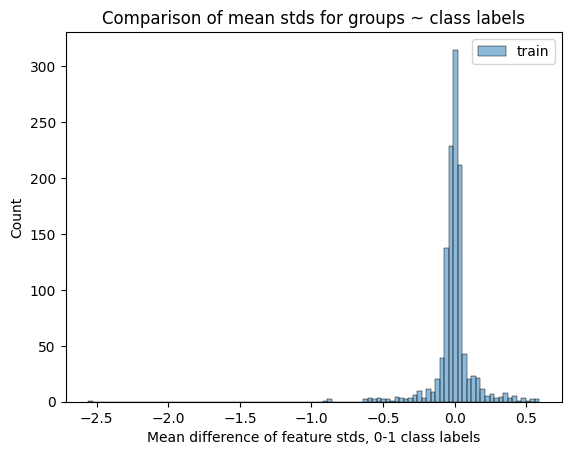

In [45]:
stds_train = []
for c in target.columns:
    stds_train.append(full_data_train.groupby(c).agg(['std']).drop(target.columns.difference([c]), axis=1))
# a way to get my mean over list of dataframes and evade 3d dataframe (stack of dataframes)
deviation_train = (sum(stds_train)/len(target.columns)).diff(1).iloc[1].reset_index()
ax = sns.histplot(deviation_train, bins=100, color='orange', label='train')
ax.set_title('Comparison of mean stds for groups ~ class labels')
ax.set_xlabel('Mean difference of feature stds, 0-1 class labels')
ax.legend()

## Univariate feature selection

In [46]:
from sklearn.feature_selection import f_classif#, SelectKBest

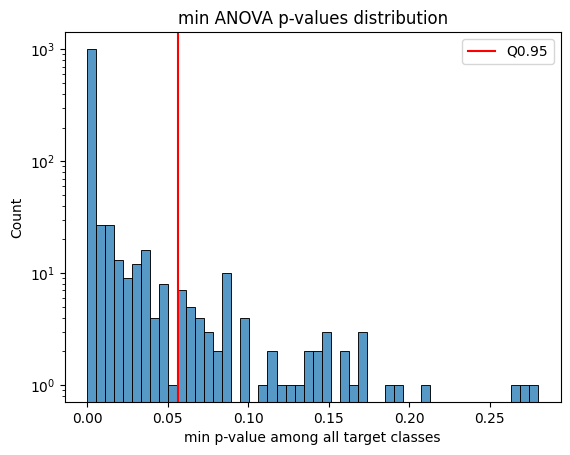

In [47]:
fc_list = []
for c in target.columns:
    fc = f_classif(train_bp, target[c])[1]
    fc_list.append(fc)
fc_arr = np.stack(fc_list, axis=0)
plt.axvline(np.quantile(fc_arr.min(axis=0), q=0.95), color='red', label='Q0.95')
ax = sns.histplot(fc_arr.min(axis=0), bins=50)
ax.set_title('min ANOVA p-values distribution')
ax.set_xlabel('min p-value among all target classes')
# ax.set_ylim((0, 100))
ax.set_yscale('log')
ax.legend()

In [48]:
univ_rejected_cols = train_bp.columns[fc_arr.min(axis=0) >= 0.05]
univ_rejected_cols

Index(['c_0495', 'c_0497', 'c_0501', 'c_0508', 'c_0512', 'c_0567', 'c_0599',
       'c_0747', 'c_0748', 'c_0781', 'c_0849', 'c_0898', 'c_0903', 'c_0904',
       'c_0964', 'c_0995', 'c_1014', 'c_1089', 'c_1119', 'c_1202', 'c_1221',
       'c_1245', 'c_1268', 'c_1272', 'c_1293', 'c_1304', 'c_1350', 'n_0003',
       'n_0024', 'n_0035', 'n_0040', 'n_0069', 'n_0076', 'n_0106', 'o_0116',
       'o_0137', 'o_0138', 'o_0148', 'o_0157', 'o_0163', 'o_0177', 'o_0179',
       'o_0190', 'o_0204', 'o_0210', 'o_0232', 'o_0235', 'o_0236', 'o_0240',
       'o_0259', 'o_0275', 'o_0284', 'o_0296', 'o_0314', 'o_0316', 'n_0004_',
       'o_0183_', 'o_0243_', 'o_0253_', 'o_0261_', 'o_0275_'],
      dtype='object')

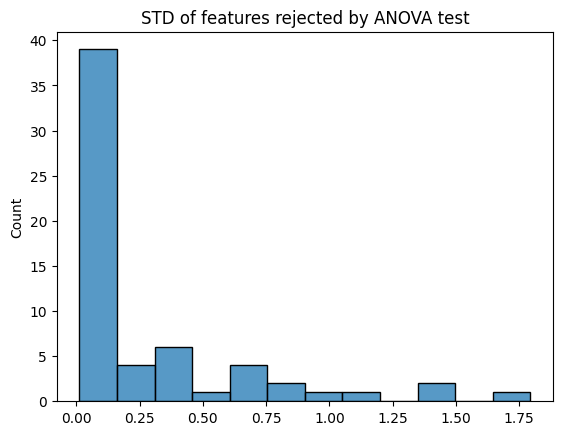

In [49]:
# check their variance to ensure that it's an adequate result
plt.title('STD of features rejected by ANOVA test')
ax= sns.histplot(train_bp[univ_rejected_cols].std())

# Multivariate feature selection

In [50]:
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

In [51]:
#feature-scaling
def_scaler = StandardScaler()
rob_scaler = RobustScaler()
train_bp_scaled_ = pd.DataFrame(def_scaler.fit_transform(train_bp), columns=def_scaler.feature_names_in_)

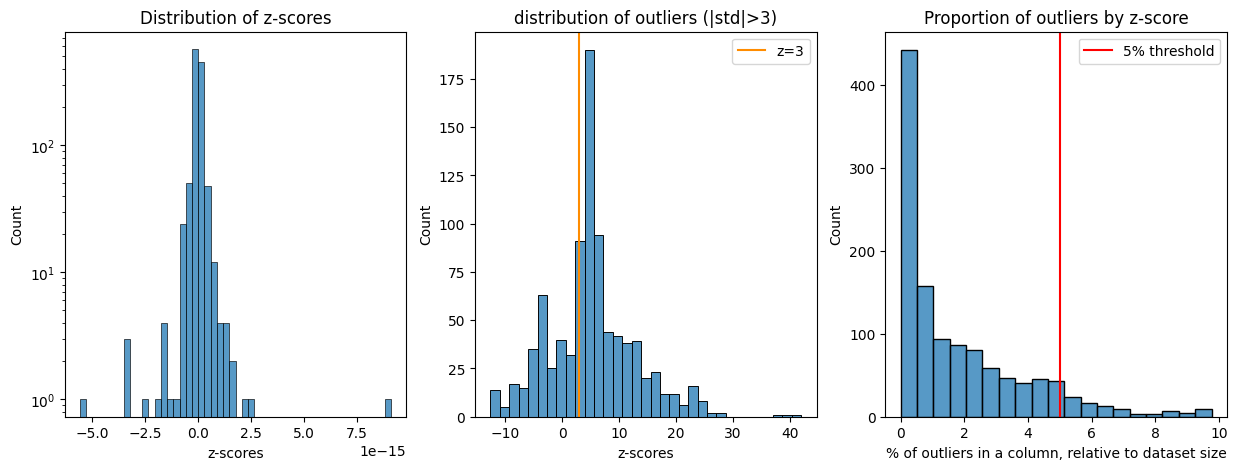

In [52]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0] = sns.histplot((train_bp_scaled_).mean(axis=0), ax=axes[0], bins=50)
axes[0].set_title('Distribution of z-scores')
axes[0].set_xlabel('z-scores')
axes[0].set_yscale('log')
axes[1] = sns.histplot((train_bp_scaled_[abs(train_bp_scaled_)>3]).mean(axis=0), ax=axes[1])
axes[1].set_title('distribution of outliers (|std|>3)')
axes[1].set_xlabel('z-scores')
axes[1].axvline(3, color='darkorange', label='z=3')
axes[1].legend()
outlier_proportion = (abs(train_bp_scaled_)>3).sum(axis=0)/train_bp_scaled_.shape[0]
axes[2] = sns.histplot(100*outlier_proportion, ax=axes[2])
axes[2].axvline(5, label='5% threshold', color='red')
axes[2].set_title('Proportion of outliers by z-score')
axes[2].set_xlabel('% of outliers in a column, relative to dataset size')
_ = axes[2].legend()

In [53]:
# select columns with high percent of outliers or huge z-scores
z_threshold = 18
pr_treshold = 5
cols_w_outliers = train_bp_scaled_.columns[(outlier_proportion>pr_treshold/100) | ((train_bp_scaled_[abs(train_bp_scaled_)>3]).mean(axis=0)>z_threshold)]
cols_rest = train_bp_scaled_.columns.difference(cols_w_outliers)
cols_w_outliers.size, cols_rest.size

(153, 1032)

In [54]:
#use robust scaler for filtered outlier columns
train_bp_scaled = train_bp_scaled_.copy()
train_bp_scaled[cols_w_outliers] = rob_scaler.fit_transform(train_bp[cols_w_outliers])
train_bp_scaled[cols_w_outliers].describe()

,c_0327,c_0328,c_0355,c_0360,c_0362,c_0386,c_0388,c_0399,c_0401,c_0414,...,o_0247_,o_0269_,o_0280_,o_0281_,o_0283_,o_0292_,o_0304_,o_0319_,o_0324_,o_0326_
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.004000,0.280000,0.002375,0.005000,0.001875,0.941750,0.001875,0.166000,0.040000,0.002375,...,-0.096875,-0.058750,-0.05075,-0.097250,-0.095625,-0.089000,-0.086125,-0.083875,-0.068750,-0.092875
std,0.080528,1.085241,0.048679,0.128363,0.048701,2.713075,0.051204,0.523907,0.259631,0.062208,...,0.295806,0.235171,0.21950,0.296316,0.294095,0.284762,0.280566,0.277218,0.253044,0.290275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,5.000000,1.000000,6.000000,2.000000,10.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [55]:
reg_strength = 100
lr = LogisticRegression(C=1/reg_strength, dual=False, max_iter=200)
svc = LinearSVC(C=1/reg_strength, penalty="l1", dual=False, max_iter=500)
cv = StratifiedKFold(n_splits=2)
X, y = train_bp_scaled, target

In [56]:
rfecv = RFECV(
    estimator=lr,
    step=1, #n_features to remove per iteration
    cv=cv,
    scoring="precision", #as classes might be unbalanced
    min_features_to_select=10,
    n_jobs=-1,
)

In [59]:
%timeit svc.fit(X, y.service_a)

2.27 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit lr.fit(X, y.service_a)

1.31 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
####### TAKES 4+ HRS DO NOT RUN

In [60]:
# multi_rfecv = MultiOutputClassifier(rfecv, n_jobs=-1)

In [61]:
# multi_rfecv.fit(X, y)

In [60]:
mrfecv_name = 'rfecv.pickle'
# pickle.dump(multi_rfecv, open(mrfecv_name, "wb"))
loaded_mrfecv = pickle.load(open(mrfecv_name, "rb"))

In [61]:
rfecv_selected_cols = pd.Index([])
for (i,e) in enumerate(loaded_mrfecv.estimators_):
    rfecv_selected_cols = rfecv_selected_cols.union(X.columns[e.support_])
    print(f'class {y.columns[i]} has {e.n_features_} optimal features incl. {X.columns[e.support_].size - X.columns[e.support_].difference(univ_rejected_cols).size} ANOVA-discarded features')
rfecv_selected_cols.shape
# univ_rejected_cols.intersection(rfecv_selected_cols)
# sns.histplot(train_bp[univ_rejected_cols.intersection(rfecv_selected_cols)].std())

class service_a has 14 optimal features incl. 0 ANOVA-discarded features
class service_b has 30 optimal features incl. 0 ANOVA-discarded features
class service_c has 27 optimal features incl. 0 ANOVA-discarded features
class service_d has 13 optimal features incl. 0 ANOVA-discarded features
class service_e has 10 optimal features incl. 0 ANOVA-discarded features
class service_f has 65 optimal features incl. 0 ANOVA-discarded features
class service_g has 30 optimal features incl. 0 ANOVA-discarded features
class service_h has 12 optimal features incl. 0 ANOVA-discarded features
class service_i has 11 optimal features incl. 0 ANOVA-discarded features
class service_j has 470 optimal features incl. 15 ANOVA-discarded features
class service_k has 842 optimal features incl. 35 ANOVA-discarded features
class service_l has 307 optimal features incl. 14 ANOVA-discarded features
class service_m has 40 optimal features incl. 0 ANOVA-discarded features
class service_n has 15 optimal features incl.

(1009,)

In [62]:
def plot_rfe_ranking(rfecv_model, ax=None, verbose=False):
    ax = sns.scatterplot(rfecv_model.ranking_, c= rfecv_model.ranking_, cmap='jet', s=0.008*(len(rfecv_model.ranking_)-rfecv_model.ranking_), ax=ax)
    if verbose:
        ax.set_title('RFECV feature ranking (lower->better)')
        ax.axhline(rfecv_model.n_features_, label=f'best {rfecv_model.n_features_}', color='red')
        ax.legend(loc='upper right')
    else:
        ax.axis('off')
    return ax
    
def plot_rfe_score(rfecv_model, ax=None, verbose=True):
    n_scores = len(rfecv_model.cv_results_["mean_test_score"])
    min_features_to_select = rfecv_model.min_features_to_select
    if not ax:
        fig, ax = plt.subplots(figsize=(10,5)) 
    ax.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv_model.cv_results_["mean_test_score"],
        yerr=rfecv_model.cv_results_["std_test_score"],
        ms=0.01,
        # label='s'
    )
    if verbose:
        ax.set_title("Recursive Feature Elimination with CV")
        ax.set_xlabel("Number of features selected")
        ax.set_ylabel("Mean test precision")
    else:
        ax.axis('off')
    ax.axvline(rfecv_model.n_features_, c='red', lw=0.5, label=f'Nf={rfecv_model.n_features_}')
    ax.legend()
    return ax

In [63]:
def multi_plot(plot_f, mrfecv_model, n_cols=5, title=None):
    n_plots = len(mrfecv_model.classes_)
    fig, axes = plt.subplots(n_plots//n_cols+1, n_cols, figsize=(15,6))
    if title:
        fig.suptitle(title, fontsize=20)
    for (i, e) in enumerate(mrfecv_model.estimators_):
        coord = i//n_cols, i % n_cols
        axes[coord] = plot_f(e, ax=axes[coord], verbose=False)
        axes[coord].set_title(f'C = {y.columns[i]}')

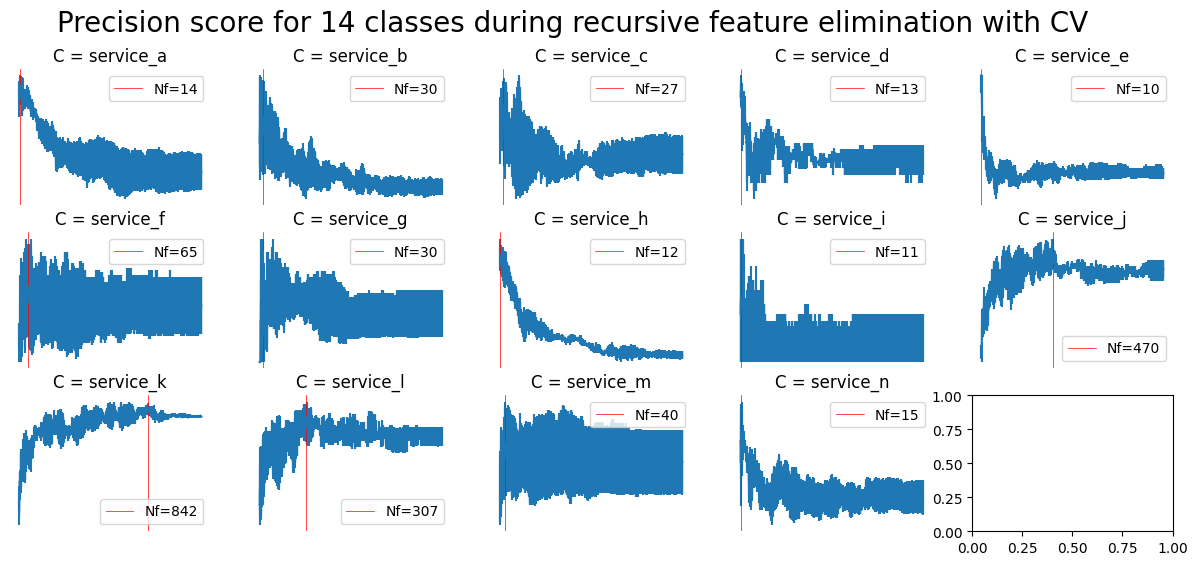

In [64]:
multi_plot(plot_rfe_score, loaded_mrfecv, title=f'Precision score for 14 classes during recursive feature elimination with CV')

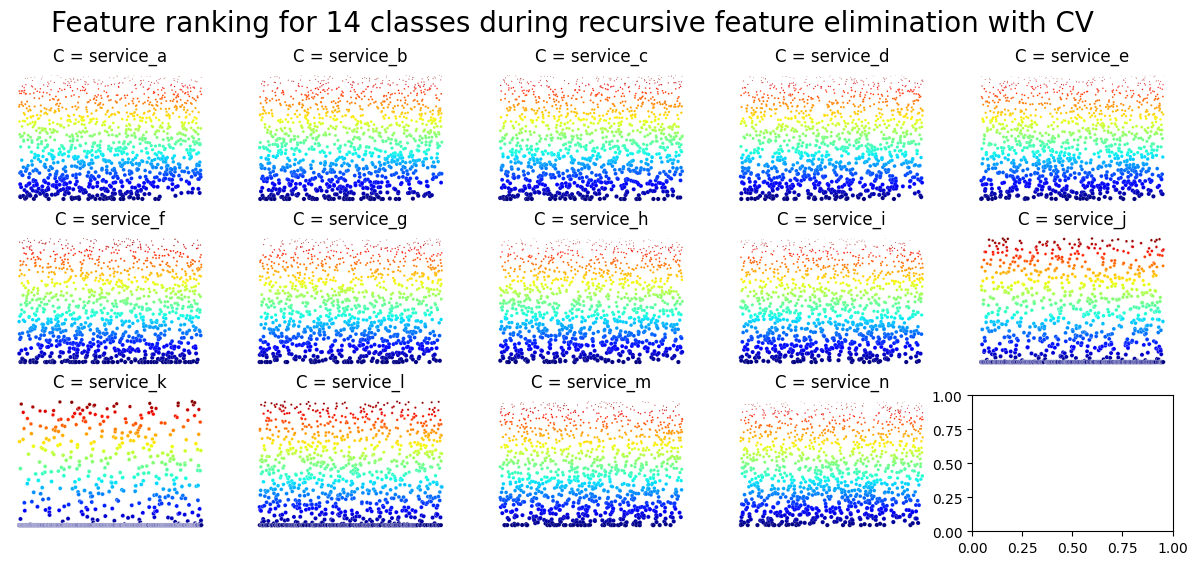

In [65]:
multi_plot(plot_rfe_ranking, loaded_mrfecv, title=f'Feature ranking for 14 classes during recursive feature elimination with CV')

In [66]:
from xgboost import XGBClassifier
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.utils.class_weight import compute_sample_weight

from collections import Counter

RSEED=42

In [67]:
from sklearn.metrics import confusion_matrix, f1_score, multilabel_confusion_matrix

In [68]:
def multi_cm_plot(X, y, model, n_cols=5, title=None, class_names=target.columns):
    n_plots = y.shape[1]
    fig, axes = plt.subplots(n_plots//n_cols+1, n_cols, figsize=(16,10))
    y_pred = model.predict(X)
    if title:
        fig.suptitle(title, fontsize=20)
    for i in range(n_plots):
        coord = i//n_cols, i % n_cols
        axes[coord] = sns.heatmap(confusion_matrix(y[:,i], y_pred[:,i]), annot=True,ax=axes[coord], cbar=False, fmt='.0f')
        axes[coord].set_title(f'{class_names[i]}, f1={f1_score(y[:,i], y_pred[:,i]):.1f}')

def mean_cm_plot(X_train, y_train, X_val, y_val, model, title=None):
    fig, axes = plt.subplots(1,2, figsize=(7,5))
    axes[0]=sns.heatmap(multilabel_confusion_matrix(y_train, model.predict(X_train)).mean(axis=0),annot=True, cbar=False, fmt='.0f', ax=axes[0])
    axes[0].set_title('train')
    axes[1]=sns.heatmap(multilabel_confusion_matrix(y_val, model.predict(X_val)).mean(axis=0),annot=True, cbar=False, fmt='.0f', ax=axes[1])
    axes[1].set_title('val')
    fig.suptitle(title, fontsize=18)

def f_score(X,y,model, label=None):
    # print(f"Coverage={coverage_error(y, model.predict_proba(X_train)):.2f}")
    print(f"{label} macro F1_score={f1_score(y, model.predict(X), average='samples'):.2f}")

# Modeling
First of all, set up stratified train, test split and it's not that simple for multilabel task:
   
- iterative train test split, splits a multi-label dataset by considering each label separately, starting from the one with the fewest positive examples

## Gradient boosting: 
- non-scaled data (pandas dataframe with categorical columns)
- deal with imbalanced classes: distribution-balanced loss -- impossible in this setup, assign sample_weights (doesn't work good)
- XGBM Classifier with multi-output support or scikit metaalgorithm (ClassifierChain/MultiOutputClassifier)

## Performance metrics:
I expect bad performance for the most imbalanced classes, we can't do much here. I can't simply use accuracy even as my evaluation metric, same for AUC-ROC here

Precision/Recall are not convenient on their own, I could use use PR-AUC (robust to class imbalance) but since I am not dealing with tradeoff anyways (what's better in this task?), I switch to their harmonic mean $F_\beta$
It combines them in such a way that if any component goes down, it also goes down (up to zero) and also allows to balance between those (higher ${\beta}$ prefers recall over precision)

- plot confusion matrix and calculate $F_1$-score per class, then apply macro averaging as I need one number
- use optuna to optimize hyperparameters
- use built-in CV with 2 folds, already given (in fact just use best hyperparameters to achieve higher score)

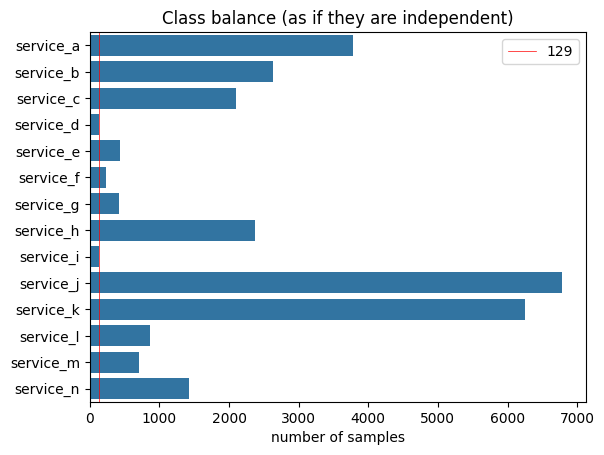

In [69]:
min_class_size = min(target.sum(axis=0))
ax = sns.barplot(target.sum(), orient='h')
ax.set_xlabel('number of samples')
ax.set_title('Class balance (as if they are independent)')
ax.axvline(min_class_size, c='red', lw=0.5, label=f'{min_class_size}')
ax.legend()

In [70]:
# put more weights onto rare class samples (inversely proportional to class frequencies in the input data)
# true_class_proportion = target.mean(axis=0)
sample_weights = compute_sample_weight(class_weight="balanced", y=y)
mean_pos_class_proportion = target.mean(axis=0).mean()
mean_neg_class_proportion = (1-target.mean(axis=0)).mean()

In [71]:
# amount of examples per label combination
# Counter(combination for row in get_combination_wise_output_matrix(y.to_numpy(), order=2) for combination in row)

In [166]:
# save original indices as a column in X as there is no other way to retrieve them after split
train_bp_w_ix = train_bp.copy()
train_bp_w_ix['temp_ix'] = train_bp.index

In [167]:
X_train_, y_train, X_val_, y_val = iterative_train_test_split(train_bp_w_ix.to_numpy(), target.to_numpy(), test_size = 0.1)

In [168]:
# workaround to extract saved indices
train_ix, val_ix = X_train_[:,-1].astype('int8'), X_val_[:,-1].astype('int8')
X_train, X_val = X_train_[:,:-1], X_val_[:,:-1] 
X_train.shape, X_val.shape

((7208, 1185), (792, 1185))

In [169]:
# re-create feature dataframe to highlight categorical 
X_train = pd.DataFrame(X_train, columns=train_bp.columns)
X_val = pd.DataFrame(X_val, columns=train_bp.columns)

In [170]:
# re-cast to int8 categorical 
cat_cols = train_bp.select_dtypes(include=['int8']).columns
X_train_cat, X_val_cat = X_train.copy(), X_val.copy()
X_train_cat[cat_cols] = X_train_cat[cat_cols].astype('int8').astype('category')
X_val_cat[cat_cols] = X_val_cat[cat_cols].astype('int8').astype('category')
# X_train_cat.dtypes.unique()

In [171]:
X_train_base = X_train[rfecv_selected_cols]
X_val_base = X_val[rfecv_selected_cols]

In [199]:
tree_params = {'n_estimators': 500,
            'learning_rate': 0.05,
            # to deal with overfitting
            'early_stopping_rounds': 25, #halt if the metric not improving for this many rounds
            'eval_metric':'logloss',
            # 'scale_pos_weight': mean_neg_class_proportion/mean_pos_class_proportion # scale positive class error according to mean proportion (~3x)
             }
opt_params = {'max_depth': 5,
            'min_child_weight': 5, # when a leaf stops further partitioning
            'gamma': 1.0, # minimal loss reduction to justify further partitioning
              }
# parameters to be passed to fit method (directly)
fit_params = {"eval_set": [(X_train_base, y_train), (X_val_base, y_val)], # NB val dataset is only used for early stopping, not for learning!
              # 'sample_weight': sample_weights[train_ix],
              # 'sample_weight_eval_set': (sample_weights[train_ix], sample_weights[val_ix]),
             }

In [200]:
xgbc_base = XGBClassifier(objective='binary:logistic', #eval_metric is same as objective
                    tree_method="hist", #faster
                    multi_strategy="multi_output_tree",
                    random_state = RSEED,
                    n_jobs=-1,
                    **tree_params,
                    **opt_params,
                    )

In [205]:
xgbc_release = XGBClassifier(objective='binary:logistic', #eval_metric is same as objective
                    tree_method="hist", #faster
                    multi_strategy="multi_output_tree",
                    random_state = RSEED,
                    n_jobs=-1,
                    #release fixes
                    n_estimators=430,
                    learning_rate=0.05,
                    **opt_params,
                    )

In [202]:
xgbc_base.fit(X_train_base, y_train, **fit_params, verbose=50)
xgbc_base.best_iteration, xgbc_base.best_score

[0]	validation_0-logloss:0.54120	validation_1-logloss:0.54797
[50]	validation_0-logloss:0.27418	validation_1-logloss:0.28806
[100]	validation_0-logloss:0.24511	validation_1-logloss:0.26963
[150]	validation_0-logloss:0.22985	validation_1-logloss:0.26438
[200]	validation_0-logloss:0.21817	validation_1-logloss:0.26230
[250]	validation_0-logloss:0.20830	validation_1-logloss:0.26080
[300]	validation_0-logloss:0.19990	validation_1-logloss:0.26043
[350]	validation_0-logloss:0.19209	validation_1-logloss:0.26010
[400]	validation_0-logloss:0.18531	validation_1-logloss:0.25980
[443]	validation_0-logloss:0.18006	validation_1-logloss:0.25971


(419, 0.2596295569765153)

In [203]:
f_score(X_train_base, y_train, xgbc_base, 'train')
f_score(X_val_base, y_val, xgbc_base, 'validation')

train macro F1_score=0.83
validation macro F1_score=0.77


In [209]:
xgbc_release.fit(train_bp[rfecv_selected_cols], target, **fit_params, verbose=20)

[0]	validation_0-logloss:0.54122	validation_1-logloss:0.54778
[20]	validation_0-logloss:0.33929	validation_1-logloss:0.34356
[40]	validation_0-logloss:0.28685	validation_1-logloss:0.29029
[60]	validation_0-logloss:0.26648	validation_1-logloss:0.26888
[80]	validation_0-logloss:0.25469	validation_1-logloss:0.25633
[100]	validation_0-logloss:0.24636	validation_1-logloss:0.24801
[120]	validation_0-logloss:0.23974	validation_1-logloss:0.24108
[140]	validation_0-logloss:0.23416	validation_1-logloss:0.23538
[160]	validation_0-logloss:0.22909	validation_1-logloss:0.23028
[180]	validation_0-logloss:0.22450	validation_1-logloss:0.22586
[200]	validation_0-logloss:0.22018	validation_1-logloss:0.22147
[220]	validation_0-logloss:0.21621	validation_1-logloss:0.21753
[240]	validation_0-logloss:0.21241	validation_1-logloss:0.21348
[260]	validation_0-logloss:0.20899	validation_1-logloss:0.20990
[280]	validation_0-logloss:0.20582	validation_1-logloss:0.20689
[300]	validation_0-logloss:0.20260	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy='multi_output_tree', n_estimators=430, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [210]:
release_model = 'xgbc_release.pickle'
pickle.dump(xgbc_release, open(release_model, "wb"))
# loaded_rm = pickle.load(open(release_model, "rb"))

## Results

Base model with 1009 features and (hyperparameter tuning on my 2-fold CV split) provides the best results $F_{train} = 0.83, F_{test} = 0.77$ (nb lowest logloss criteria), I consider 5 more cases over that:

1) discard more features, i.e. all univariate rejection set => performance degrades a bit
2) provide dataframe w/ categorical dtype to utilise categorical splits feature => bad performance
1) scale positive class loss with mean disproportion (3N:1P) => F1_score raises over Logloss
2) use sample weighing => bad performance
3) use ClassifierChain wrapper with binary XGBoost and random class order => same performance as my base case

I will stick to my base case and restrict n_estimators in accordance with that behaviour, then test on whole dataset before release

In [97]:
# additionally discard whole univariate selection from feature set
X_train_univ_rejected = X_train[rfecv_selected_cols.difference(univ_rejected_cols)]
X_val_univ_rejected = X_val[rfecv_selected_cols.difference(univ_rejected_cols)]
fit_params_univ_rejected = {"eval_set": [(X_train_univ_rejected, y_train), (X_val_univ_rejected, y_val)], # NB val dataset is only used for early stopping, not for learning!
              # 'sample_weight': sample_weights[train_ix],
              # 'sample_weight_eval_set': (sample_weights[train_ix], sample_weights[val_ix]),
             }
xgbc_univ_rejected = XGBClassifier(objective='binary:logistic', #eval_metric is same as objective
                    tree_method="hist", #faster
                    enable_categorical=True, #automatically detect categoricals in dataframe 
                    multi_strategy="multi_output_tree",
                    random_state = RSEED,
                    n_jobs=-1,
                    **tree_params,
                    **opt_params,
                    )

In [98]:
xgbc_univ_rejected.fit(X_train_univ_rejected, y_train, **fit_params_univ_rejected, verbose=50)
f_score(X_train_univ_rejected, y_train, xgbc_univ_rejected, 'train')
f_score(X_val_univ_rejected, y_val, xgbc_univ_rejected, 'validation')
xgbc_univ_rejected.best_iteration, xgbc_univ_rejected.best_score

[0]	validation_0-logloss:0.52788	validation_1-logloss:0.53599
[50]	validation_0-logloss:0.26391	validation_1-logloss:0.28446
[100]	validation_0-logloss:0.24181	validation_1-logloss:0.27367
[150]	validation_0-logloss:0.22885	validation_1-logloss:0.27092
[200]	validation_0-logloss:0.21863	validation_1-logloss:0.27064
[205]	validation_0-logloss:0.21777	validation_1-logloss:0.27054
train macro F1_score=0.79
validation macro F1_score=0.74


(196, 0.2704466132157818)

In [760]:
#scale positive class penalty to correct class balance
tree_params_spw = {'n_estimators': 206,
            'learning_rate': 0.08,
            # to deal with overfitting
            'early_stopping_rounds': 25, #halt if the metric not improving for this many rounds
            'eval_metric':'logloss',
            'scale_pos_weight': mean_neg_class_proportion/mean_pos_class_proportion # scale positive class error according to mean disproportion (~3x)
             }
xgbc_base_spw = XGBClassifier(objective='binary:logistic', #eval_metric is same as objective
                    tree_method="hist", #faster
                    enable_categorical=True, #automatically detect categoricals in dataframe 
                    multi_strategy="multi_output_tree",
                    random_state = RSEED,
                    n_jobs=-1,
                    **tree_params_spw,
                    **opt_params,
                    )

In [761]:
xgbc_base_spw.fit(X_train_base, y_train, **fit_params, verbose=50)
f_score(X_train_base, y_train, xgbc_base_spw, 'train')
f_score(X_val_base, y_val, xgbc_base_spw, 'validation')
xgbc_base_spw.best_iteration, xgbc_base_spw.best_score

[0]	validation_0-logloss:0.57665	validation_1-logloss:0.57925
[50]	validation_0-logloss:0.29824	validation_1-logloss:0.31456
[100]	validation_0-logloss:0.26597	validation_1-logloss:0.29892
[150]	validation_0-logloss:0.24512	validation_1-logloss:0.29333
[200]	validation_0-logloss:0.22828	validation_1-logloss:0.29034
[205]	validation_0-logloss:0.22690	validation_1-logloss:0.29010
train macro F1_score=0.82
validation macro F1_score=0.77


(204, 0.29009909774154813)

In [764]:
# use sample weights to correct imbalance
xgbc_base_weighed = XGBClassifier(objective='binary:logistic', #eval_metric is same as objective
                    tree_method="hist", #faster
                    enable_categorical=True, #automatically detect categoricals in dataframe 
                    multi_strategy="multi_output_tree",
                    random_state = RSEED,
                    n_jobs=-1,
                    **tree_params_spw,
                    **opt_params,
                    )
# parameters to be passed to fit method (directly)
fit_params_weighed = {"eval_set": [(X_train_base, y_train), (X_val_base, y_val)], # NB val dataset is only used for early stopping, not for learning!
              'sample_weight': sample_weights[train_ix],
              'sample_weight_eval_set': (sample_weights[train_ix], sample_weights[val_ix]),
             }

In [765]:
xgbc_base_weighed.fit(X_train_base, y_train, **fit_params_weighed, verbose=50)
f_score(X_train_base, y_train, xgbc_base_weighed, 'train')
f_score(X_val_base, y_val, xgbc_base_weighed, 'validation')
xgbc_base_weighed.best_iteration, xgbc_base_weighed.best_score

[0]	validation_0-logloss:0.52621	validation_1-logloss:0.59881
[40]	validation_0-logloss:0.03684	validation_1-logloss:0.51064
train macro F1_score=0.67
validation macro F1_score=0.67


(16, 0.48489151254252405)

In [757]:
# perform partition-based categorical splits (experimental)
X_train_cat = X_train_cat[rfecv_selected_cols]
X_val_cat = X_val_cat[rfecv_selected_cols]
fit_params_cat = {"eval_set": [(X_train_cat, y_train), (X_val_cat, y_val)], # NB val dataset is only used for early stopping, not for learning!
              # 'sample_weight': sample_weights[train_ix],
              # 'sample_weight_eval_set': (sample_weights[train_ix], sample_weights[val_ix]),
             }
xgbc_cat = XGBClassifier(objective='binary:logistic', #eval_metric is same as objective
                    tree_method="hist", #faster
                    enable_categorical=True, #automatically detect categoricals in dataframe 
                    multi_strategy="multi_output_tree",
                    random_state = RSEED,
                    n_jobs=-1,
                    **tree_params,
                    **opt_params,
                    )

In [758]:
xgbc_cat.fit(X_train_cat, y_train, **fit_params_cat, verbose=50)
f_score(X_train_cat, y_train, xgbc_cat, 'train')
f_score(X_val_cat, y_val, xgbc_cat, 'validation')
xgbc_cat.best_iteration, xgbc_cat.best_score

[0]	validation_0-logloss:0.52757	validation_1-logloss:0.54085
[50]	validation_0-logloss:0.25376	validation_1-logloss:0.40823
[71]	validation_0-logloss:0.24016	validation_1-logloss:0.41509
train macro F1_score=0.66
validation macro F1_score=0.67


(47, 0.4045033104690955)

In [767]:
# pd.DataFrame(xgbc_base.feature_importances_, index=rfecv_selected_cols).sort_values(0, ascending=True)[:10].plot.barh()

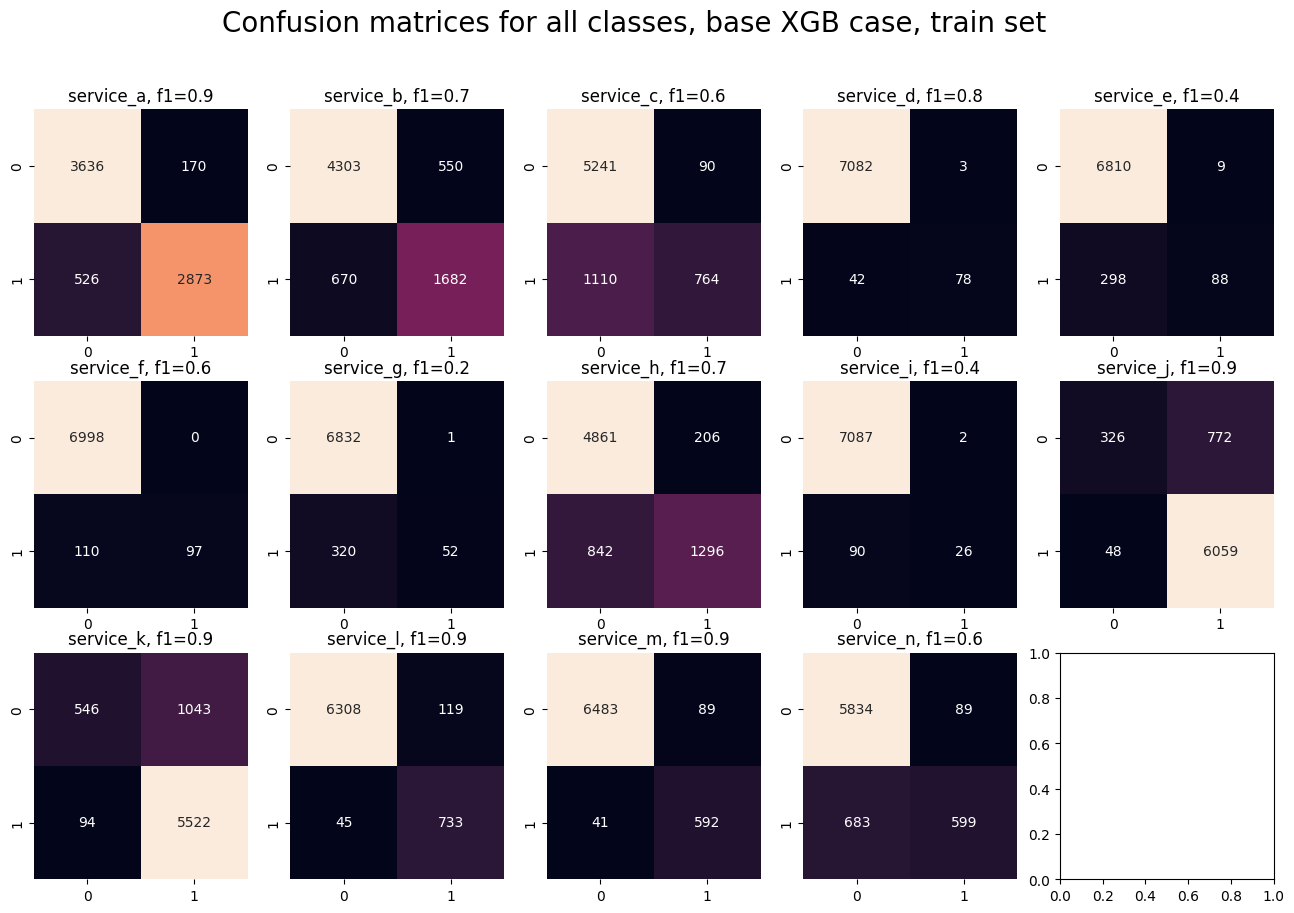

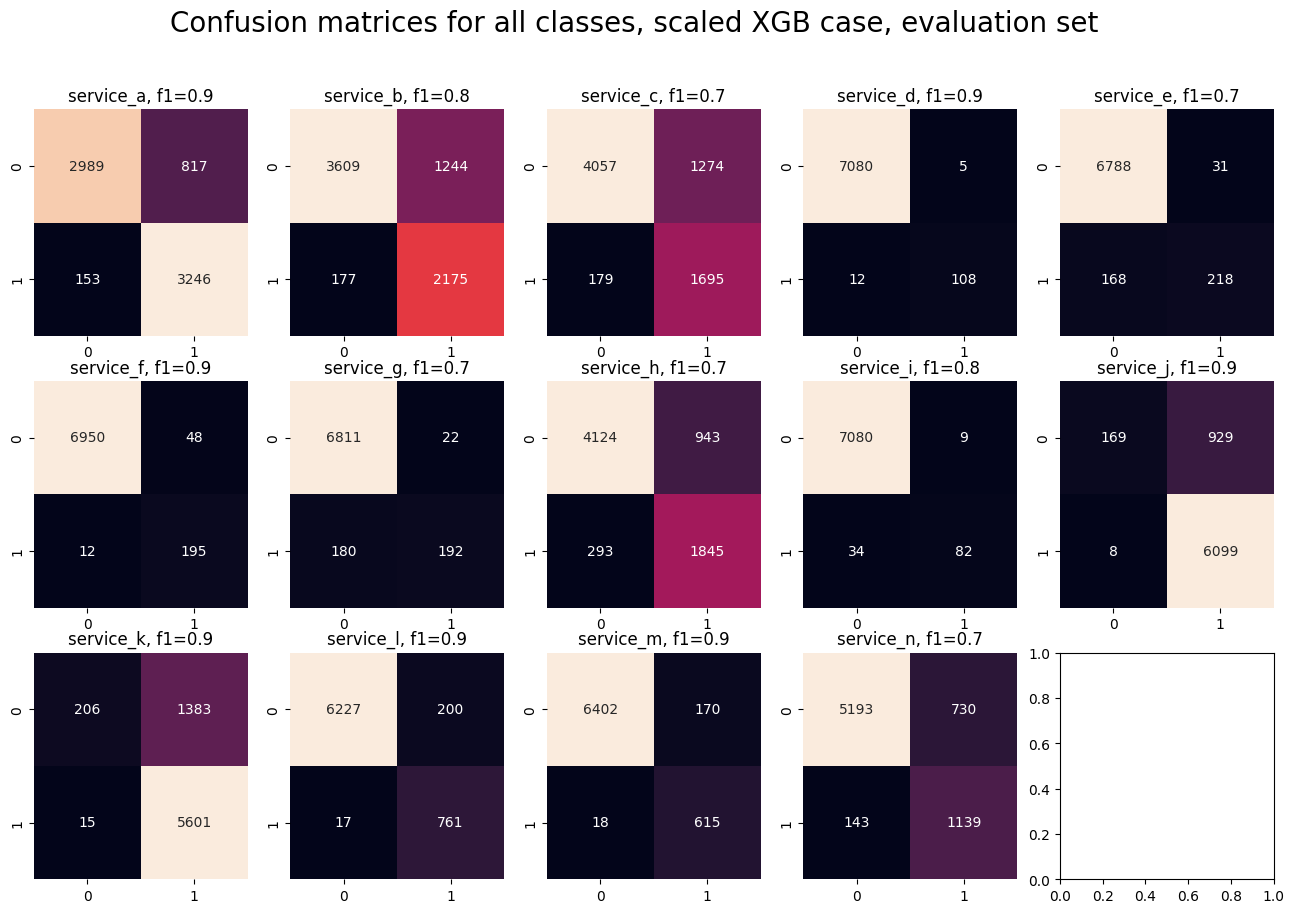

In [804]:
multi_cm_plot(X_train_base, y_train, xgbc_base, title='Confusion matrices for all classes, base XGB case, train set')
multi_cm_plot(X_train_base, y_train, xgbc_base_spw, title='Confusion matrices for all classes, scaled XGB case, evaluation set')

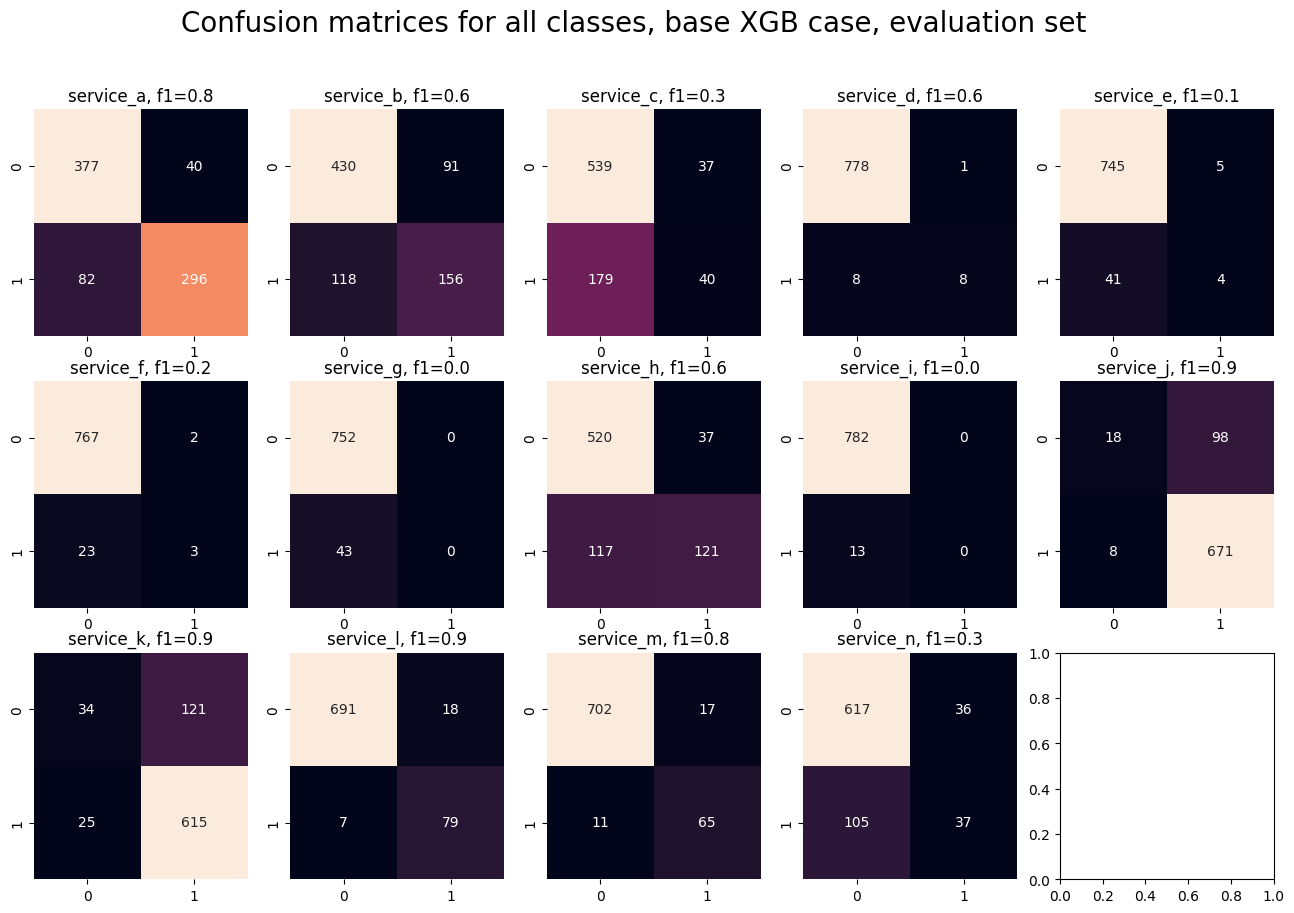

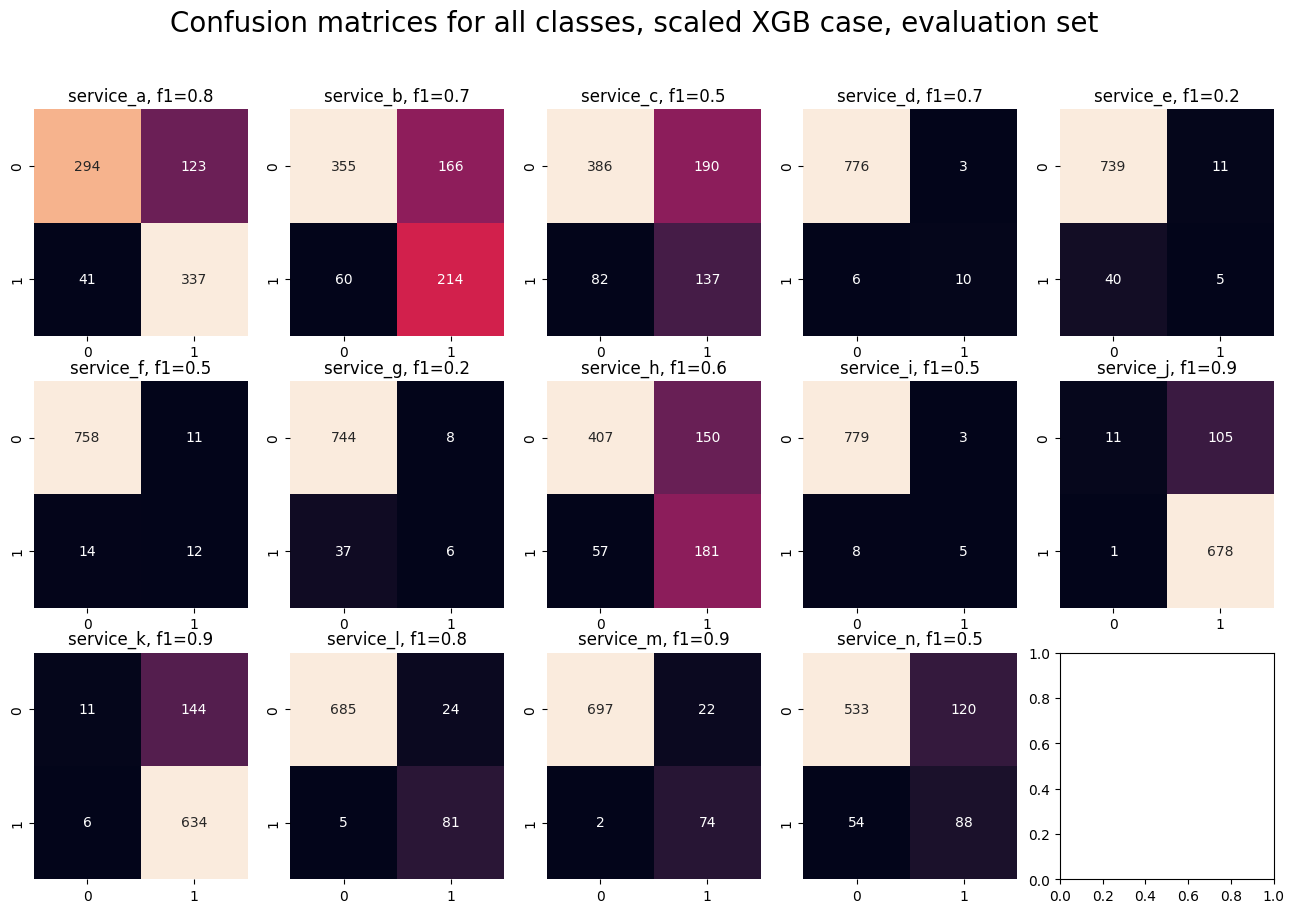

In [803]:
multi_cm_plot(X_val_base, y_val, xgbc_base, title='Confusion matrices for all classes, base XGB case, evaluation set')
multi_cm_plot(X_val_base, y_val, xgbc_base_spw, title='Confusion matrices for all classes, scaled XGB case, evaluation set')

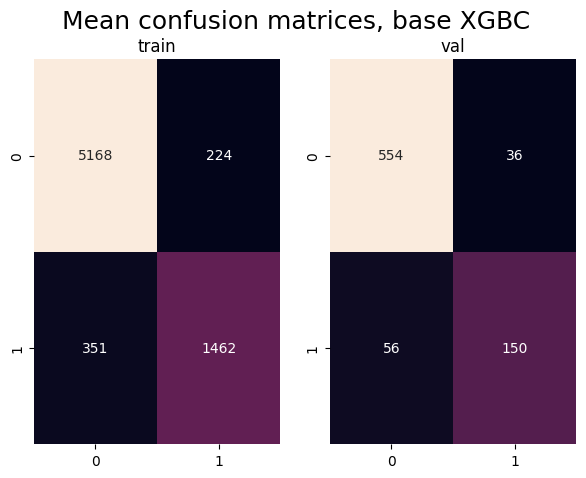

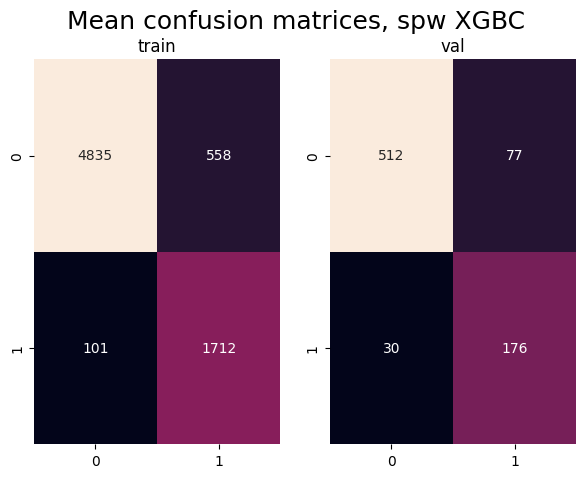

In [812]:
mean_cm_plot(X_train_base, y_train, X_val_base, y_val, xgbc_base, title='Mean confusion matrices, base XGBC')
mean_cm_plot(X_train_base, y_train, X_val_base, y_val, xgbc_base_spw, title='Mean confusion matrices, spw XGBC')

In [221]:
import optuna

In [222]:
study = optuna.create_study(direction='maximize')

[I 2024-01-19 22:55:43,577] A new study created in memory with name: no-name-7618aadb-6086-4a8d-9bad-d61dec37a311


In [223]:
def objective(trial):
    """Define the objective function"""
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, step=0.06),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0, step=1.0),
    }
    # Fit the model
    optuna_model = XGBClassifier(objective='binary:logistic', 
                    tree_method="hist", 
                    enable_categorical=True, 
                    multi_strategy="multi_output_tree",
                    random_state = RSEED,
                    n_jobs=-1,
                    **tree_params,
                    **params,)
    optuna_model.fit(X_train, y_train, **fit_params, verbose=False)
    # Predict
    y_pred = optuna_model.predict(X_val)
    # evaluate
    score = f1_score(y_val, y_pred, average='samples')
    return score

In [224]:
study.optimize(objective, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-01-19 22:57:11,625] Trial 0 finished with value: 0.7547310245465878 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'gamma': 1.0}. Best is trial 0 with value: 0.7547310245465878.
[I 2024-01-19 22:58:29,631] Trial 1 finished with value: 0.7582449427161595 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'gamma': 6.0}. Best is trial 1 with value: 0.7582449427161595.
[I 2024-01-19 22:59:50,438] Trial 2 finished with value: 0.7546784084098811 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'gamma': 8.0}. Best is trial 1 with value: 0.7582449427161595.
[I 2024-01-19 23:01:32,552] Trial 3 finished with value: 0.7561531539461701 and parameters: {'max_depth': 2, 'min_child_weight': 2, 'gamma': 2.0}. Best is trial 1 with value: 0.7582449427161595.
[I 2024-01-19 23:03:25,275] Trial 4 finished with value: 0.7561633950352145 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 3.0}. Best is trial 1 with value: 0.7582449427161595.
[I 2024-01-19 23:05:08,12

In [239]:
study.best_params
# best = {'max_depth': 4, 'min_child_weight': 5, 'gamma': 8.0}

{'max_depth': 4, 'min_child_weight': 5, 'gamma': 8.0}

In [818]:
xgbcc = XGBClassifier(objective='binary:logistic', #eval_metric is same as objective
                    tree_method="hist", #faster
                    enable_categorical=True, #automatically detect categoricals in dataframe 
                    random_state = RSEED,
                    n_jobs=-1,
                    n_estimators=500,
                    learning_rate=0.08,
                    **opt_params,
                    )

In [819]:
xgbc_chain = ClassifierChain(base_estimator=xgbcc, 
                             order='random', 
                             random_state=RSEED, 
                             verbose=True, 
                             )

In [821]:
xgbc_chain.fit(X_train_base, y_train)

[Chain] .................. (1 of 14) Processing order 9, total=   2.9s
[Chain] ................. (2 of 14) Processing order 11, total=   3.3s
[Chain] .................. (3 of 14) Processing order 0, total=   2.9s
[Chain] ................. (4 of 14) Processing order 12, total=   2.9s
[Chain] .................. (5 of 14) Processing order 5, total=   3.5s
[Chain] .................. (6 of 14) Processing order 8, total=   3.4s
[Chain] .................. (7 of 14) Processing order 2, total=   3.7s
[Chain] .................. (8 of 14) Processing order 1, total=   3.5s
[Chain] ................. (9 of 14) Processing order 13, total=   4.4s
[Chain] ................. (10 of 14) Processing order 4, total=   4.9s
[Chain] ................. (11 of 14) Processing order 7, total=   4.6s
[Chain] ................ (12 of 14) Processing order 10, total=   4.0s
[Chain] ................. (13 of 14) Processing order 3, total=   3.5s
[Chain] ................. (14 of 14) Processing order 6, total=   4.6s


ClassifierChain(base_estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=True,
                                             eval_metric=None,
                                             feature_types=None, gamma=3.0,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.08, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=5,
                                             max_leaves=None,
                                             min_child_weight=5, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=500, n_jobs=-1,
                                             num_parallel_tree=None,
                                             random_state=42, ...),
                order='random', random_state=42, verbose=True)

In [822]:
f_score(X_train_base, y_train, xgbc_chain, 'train')
f_score(X_val_base, y_val, xgbc_chain, 'test')

train macro F1_score=0.81
test macro F1_score=0.76


In [ ]:
# multi_cm_plot(X_val, y_val, xgbc_chain)

In [212]:
def predict_test(test_dframe, model, labels_train, chosen_features):
    '''Performs base preprocessing similar to train dataframe, evaluates model and outputs dataframe with probabilities and old idx, 
     overwrites existing file'''
    X_test = base_preprocessing(test_dframe)
    y_pred_test = model.predict_proba(X_test[chosen_features])
    result = pd.concat([test_dframe.id, pd.DataFrame(y_pred_test, columns=labels_train.drop(['id'], axis=1).columns)], axis=1)
    return result

In [213]:
save(predict_test(test_df, xgbc_release, labels_df, rfecv_selected_cols))

New DataFrame (2000, 1185) has been created from (2000, 1379); contains 0 NaNs
[dtype('int64') dtype('int8') dtype('float64')]
0.329MB csv file data\problem_test_labels.csv has been saved successfully
